# Plot helicity calculations

1. Plot all helicites relative and gague dependent in linear and log plots
2. Plot normalized helicities in linear and log plots.
3. Plot ffts of all helicities, to get an fft from a single period reflect the singnal once at both ends

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as axisartist

In [2]:
from scipy.constants import proton_mass as m_i
from scipy.constants import elementary_charge as q_e
import scipy.fftpack as fft
from scipy.signal import boxcar, convolve

In [3]:
cross_helicity = np.loadtxt('../../writing_to_vtk/output/2017-01-08-23-02/cross_helicity.txt')
kinetic_helicity = np.loadtxt('../../writing_to_vtk/output/2017-01-08-23-02/kinetic_helicity.txt')
magnetic_helicity = np.loadtxt('../../writing_to_vtk/output/2017-01-08-23-02/magnetic_helicity.txt')
relative_cross_helicity = np.loadtxt('../../writing_to_vtk/output/2017-01-08-23-02/relative_cross_helicity.txt')
relative_kinetic_helicity = np.loadtxt('../../writing_to_vtk/output/2017-01-08-23-02/relative_kinetic_helicity.txt')
relative_magnetic_helicity = np.loadtxt('../../writing_to_vtk/output/2017-01-08-23-02/relative_magnetic_helicity.txt')
time = np.arange(0, 250) * 0.068
helicities = {'kinetic': kinetic_helicity,
              'cross': cross_helicity, 
              'magnetic': magnetic_helicity,
              'relative_kinetic': relative_kinetic_helicity,
              'relative_cross': relative_cross_helicity,
              'relative_magnetic': relative_magnetic_helicity,
              'time': time}

### Develop plots to compare helicities

In [4]:
def compare_helicities(helicities,
                       kinetic=True, relative_kinetic=True,
                       cross=True, relative_cross=True,
                       magnetic=True, relative_magnetic=True,
                       scale='linear', S_0_velocity=None, dim=True, normalize=False,
                       norm_rel=1., norm=1., nondim_factors=None, labels_case='default',
                       nondim=False, axes=None, absolute=False, filter_width_cross=None,
                       filter_width_kinetic=None, ylim=None, add_cross_magnetic=False, add_three=False):
    assert (scale == 'linear' or scale == 'log' or 
            scale == 'symlog'), "scale must be one of linear, log or symlog" 
    assert (S_0_velocity is None or S_0_velocity == 'u_alfven' or 
            S_0_velocity == 'u_sound'), "dimless must be one of None, u_alfven, u_sound"
    
    labels = {'kinetic': r'$\mathcal{H}$',
              'relative_kinetic': r'$\mathcal{H}_{rel}$',
              'cross': r'$X$',
              'relative_cross': r'$\mathcal{X}_{rel}$',
              'magnetic': r'$\mathcal{K}$',
              'relative_magnetic': r'$\mathcal{K}_{rel}$'}
    
    labels_dimless = {'kinetic': r'$S^2_0$ $\mathcal{H}$',
                      'relative_kinetic': r'$S^2_0$ $\mathcal{H}_{rel}$',
                      'cross': r'$S_0$ $\mathcal{X}$',
                      'relative_cross': r'$S_0$ \mathcal{X}_{rel}$',
                      'magnetic': r'$\mathcal{K}$',
                      'relative_magnetic': r'$S^2_0 \mathcal{K}_{rel}$'}
    
    labels_norm = {'kinetic': r'$\bar{\mathcal{H}}$',
                   'relative_kinetic': r'$\bar{\mathcal{H}}_{rel}$',
                   'cross': r'$\bar{\mathcal{X}}$',
                   'relative_cross': r'$\bar{\mathcal{X}}_{rel}$',
                   'magnetic': r'$\bar{\mathcal{K}}$',
                   'relative_magnetic': r'$\bar{\mathcal{K}}_{rel}$'}
    
    labels_norm_dimless = {'kinetic': r'$S^2_0$ $\bar{\mathcal{H}}$',
                           'relative_kinetic': r'$S^2_0$ $\bar{\mathcal{H}}_{rel}$',
                           'cross': r'$S_0$ $\bar{\mathcal{X}}$',
                           'relative_cross': r'$S_0$ $\bar{\mathcal{X}}_{rel}$',
                           'magnetic': r'$\bar{\mathcal{K}}$',
                           'relative_magnetic': r'$\bar{\mathcal{K}}_{rel}$'}
    
    labels_dict = {'default': labels, 'dimless': labels_dimless,
                   'norm': labels_norm, 'norm_dimless': labels_norm_dimless}
    
    labels = labels_dict[labels_case]
    
    m_0 = 1.67*10**-27 
    q_0 = 1.6*10**-19
    l_0 = 0.5
    B_0 = 0.02
    u_0_a = 1.4*10**5
    u_0_cs = 20*10**3
    
    if nondim:
        kinetic_divider = m_0**2 * u_0_a**2 * l_0**4 
        cross_divider = m_0*q_0 * u_0_a * B_0*l_0**3
        magnetic_divider = q_0**2*B_0**2*l_0**4
    else:
        kinetic_divider = 1. 
        cross_divider = 1.
        magnetic_divider = 1.
    
    if S_0_velocity == 'u_alfven':
        S_0 = 7.        
    elif S_0_velocity == 'u_sound':
        S_0 = 50.
    else:
        S_0 = 1.
    
    if not axes:
        axes = plt.gca()
        
    if normalize == 'rel':
        mag_max = (helicities['relative_magnetic']/norm_rel/magnetic_divider).max()
    elif normalize == 'abs':
        mag_max = (helicities['magnetic']/norm/magnetic_divider).max()
    else:
        mag_max = 1

    time = helicities['time']
    
    keys = helicities.keys()
    keys.remove('time')
    helicities_to_plot = {}
    for key in keys:
        if absolute:
            helicities_to_plot[key] = np.abs(helicities[key])
        else:
            helicities_to_plot[key] = helicities[key]
        
    
    if kinetic:
        axes.plot(time, helicities_to_plot['kinetic']/norm/kinetic_divider*S_0**2/mag_max, 
                c='blue', ls='--', label=labels['kinetic'])
    if relative_kinetic:
        if filter_width_kinetic:
            box = boxcar(filter_width_kinetic)/filter_width_kinetic
            signal = np.asarray(helicities_to_plot['relative_kinetic']*S_0**2/norm_rel/kinetic_divider/mag_max)
            signal_filt = convolve(signal, box, mode='same')
            kinetic_final = np.asarray(signal_filt)
            axes.plot(time, signal_filt, c='blue', ls='-', label=labels['relative_kinetic'])
            axes.plot(time, signal, 
                      c='blue', alpha=0.2)
        else:
            kinetic_final = helicities_to_plot['relative_kinetic']*S_0**2/norm_rel/kinetic_divider/mag_max
            axes.plot(time, helicities_to_plot['relative_kinetic']*S_0**2/norm_rel/kinetic_divider/mag_max, 
                      c='blue', ls='-', label=labels['relative_kinetic'])
    if cross:
        axes.plot(time, helicities_to_plot['cross']/norm*S_0/cross_divider/mag_max, 
                 c='green', ls='--', label=labels['cross'])
    if relative_cross:
        if filter_width_cross:
            box = boxcar(filter_width_cross)/filter_width_cross
            signal = np.asarray(helicities_to_plot['relative_cross']*S_0/norm_rel/cross_divider/mag_max)
            signal_filt = convolve(signal, box, mode='same')
            cross_final = np.asarray(signal_filt)
            axes.plot(time, signal_filt, c='green', ls='-', label=labels['relative_cross'])
            axes.plot(time, signal, 
                      c='green', alpha=0.4)
        else:
            cross_final = helicities_to_plot['relative_cross']/norm_rel*S_0/cross_divider/mag_max
            axes.plot(time, helicities_to_plot['relative_cross']/norm_rel*S_0/cross_divider/mag_max, 
                      c='green', ls='-', label=labels['relative_cross'])
    if magnetic:
        axes.plot(time, helicities_to_plot['magnetic']/norm/magnetic_divider/mag_max, 
                 c='red', ls='--', label=labels['magnetic'])
    if relative_magnetic:
        magnetic_final = helicities_to_plot['relative_magnetic']/norm_rel/magnetic_divider/mag_max
        axes.plot(time, helicities_to_plot['relative_magnetic']/norm_rel/magnetic_divider/mag_max, 
                 c='red', ls='-', label=labels['relative_magnetic'])
    axes.set_xlabel(r'$t$ [$\mu s$]')
    axes.set_yscale(scale)
    axes.set_ylabel(r'$K$ [$J$ $kg$ $m^2$]')
    if normalize:
        axes.set_ylabel(r'$K$ [-]')

    if ylim:
        axes.set_ylim(ylim)
    if add_cross_magnetic:
        axes.plot(time, cross_final + magnetic_final, 
                  c='yellow', ls='-', label=labels['relative_magnetic'] + " $+$ " + labels['relative_cross'])
    if add_three:
        axes.plot(time, kinetic_final + cross_final + magnetic_final, 
                  c='black', ls='-', label=labels['relative_magnetic'] + " $+$ " + labels['relative_cross'] + " $+$ " + labels['relative_kinetic'])
    axes.legend(loc='best', fancybox=True, frameon=True, framealpha=0.9)
    return axes

#  Gauge Dependent Helicities 

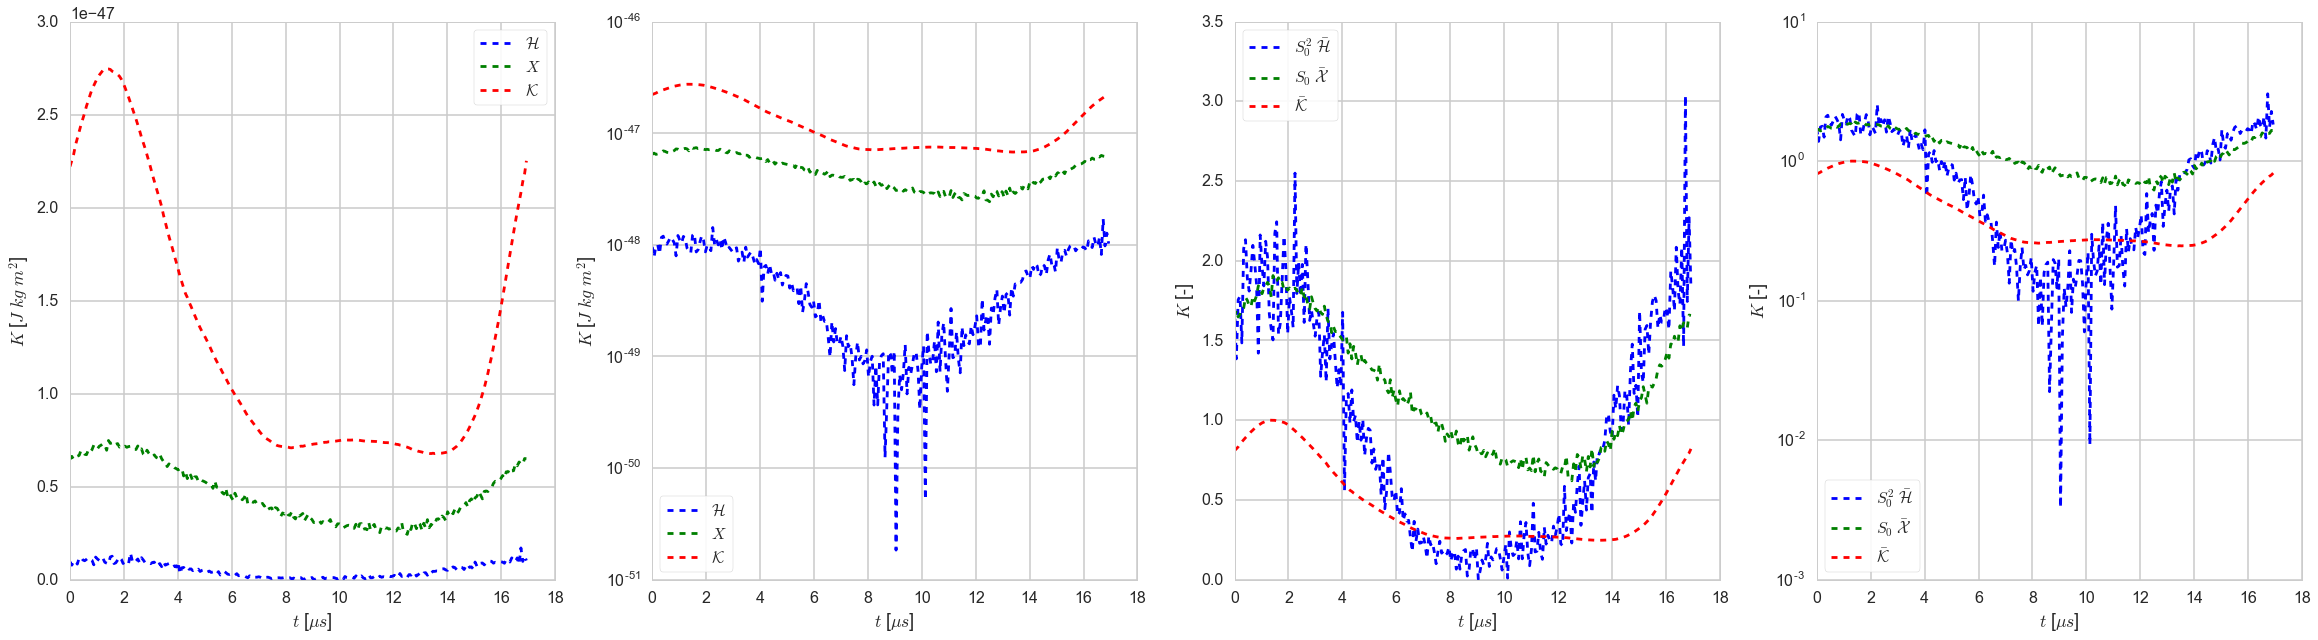

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(40,10))
axes[0] = compare_helicities(helicities, axes=axes[0],
                             relative_magnetic=False, relative_kinetic=False, relative_cross=False)
axes[1] = compare_helicities(helicities, scale='log',
                             relative_magnetic=False, relative_kinetic=False, relative_cross=False,
                             axes=axes[1])
axes[2] = compare_helicities(helicities, S_0_velocity='u_alfven',
                             labels_case="norm_dimless", 
                             normalize='abs',
                             relative_magnetic=False, relative_kinetic=False, relative_cross=False,
                             axes=axes[2])
axes[3] = compare_helicities(helicities, scale='log', 
                             S_0_velocity='u_alfven', 
                             relative_magnetic=False, relative_kinetic=False, relative_cross=False,
                             normalize='abs', axes=axes[3],
                             labels_case="norm_dimless")
plt.show()

# Gauge dependent (dotted) and relative (solid) Helicities 

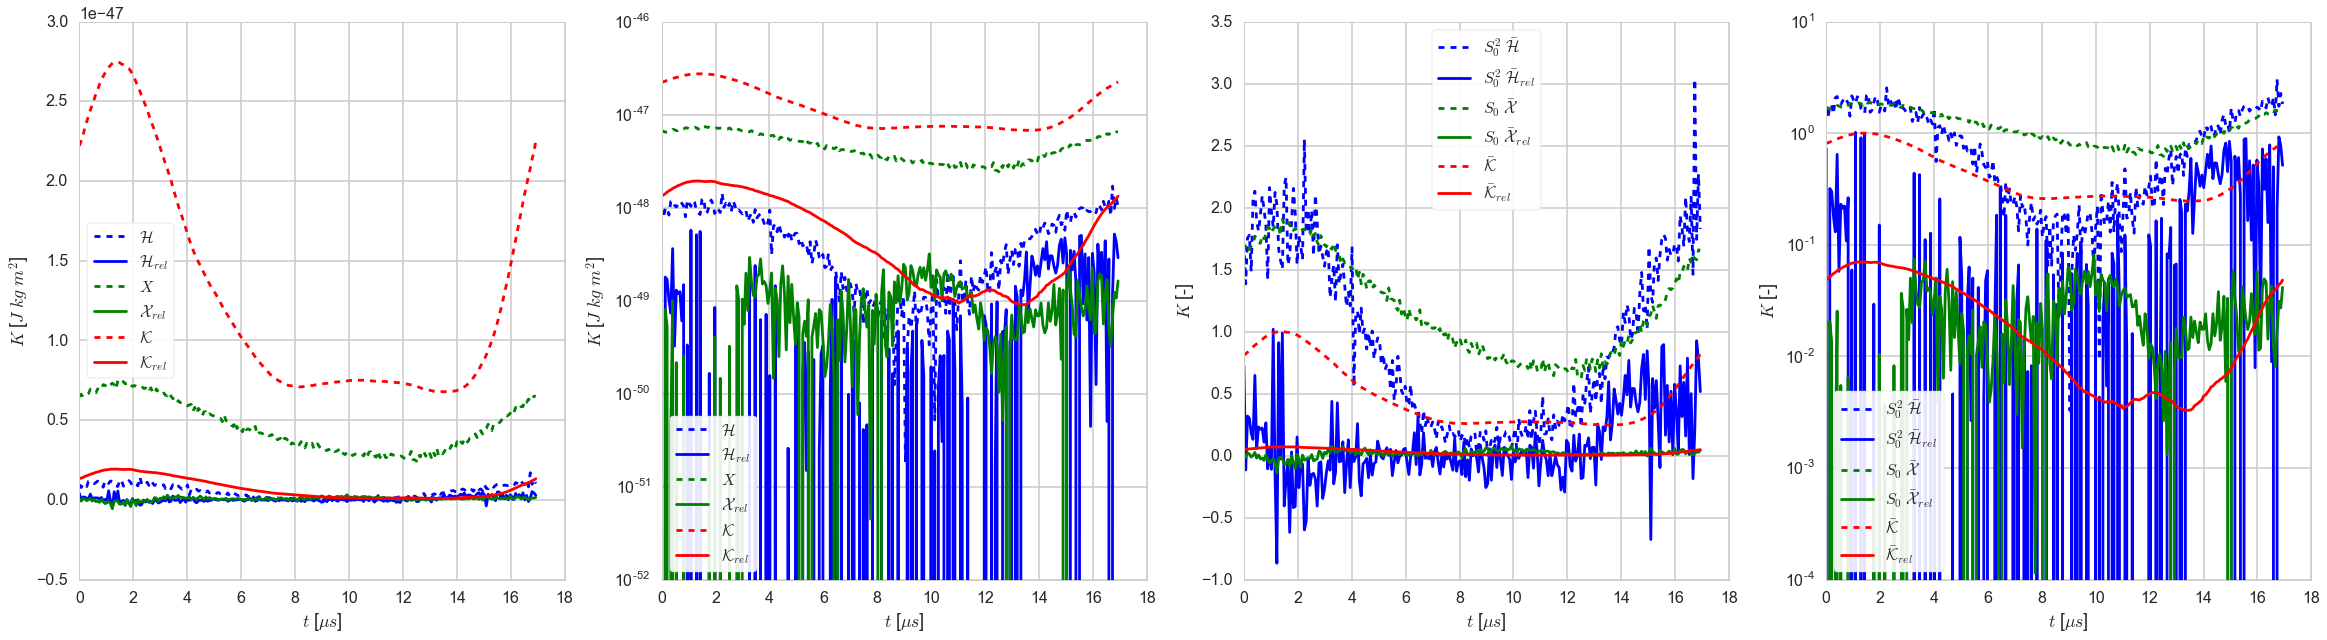

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(40,10))
axes[0] = compare_helicities(helicities, axes=axes[0])
axes[1] = compare_helicities(helicities, scale='log', 
                             axes=axes[1])
axes[2] = compare_helicities(helicities, S_0_velocity='u_alfven',
                             labels_case="norm_dimless", 
                             normalize='abs', axes=axes[2])
axes[3] = compare_helicities(helicities, scale='log', 
                             S_0_velocity='u_alfven', 
                             normalize='abs', axes=axes[3],
                             labels_case="norm_dimless")
plt.show()

# Relative (solid) Helicities go negative, take absolute value 

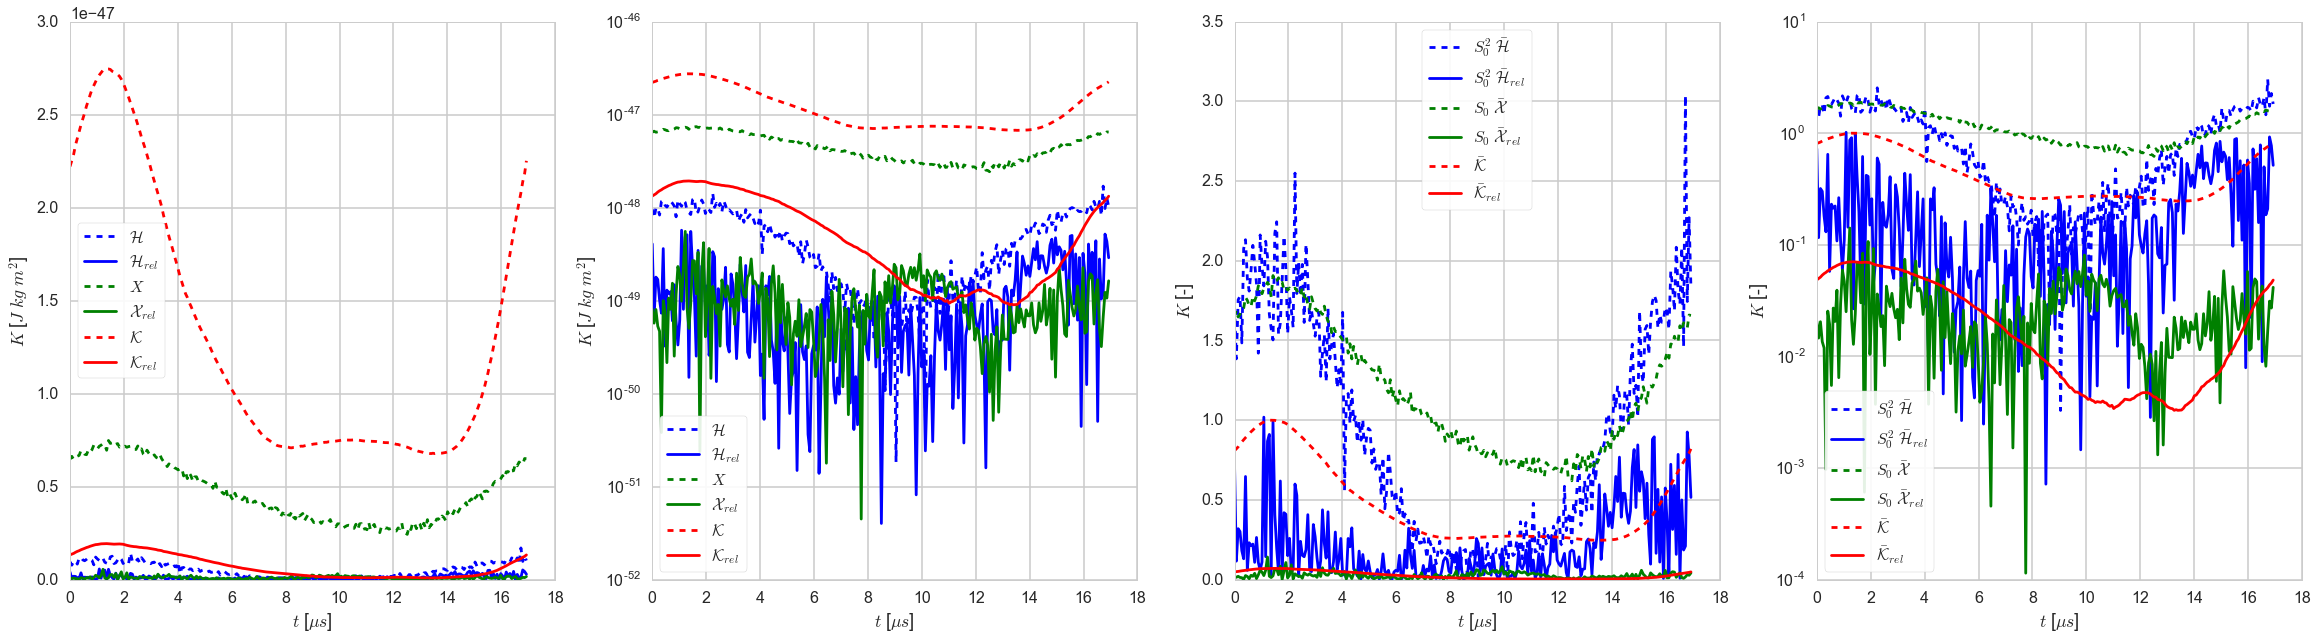

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(40,10))
axes[0] = compare_helicities(helicities, axes=axes[0], 
                             absolute=True)
axes[1] = compare_helicities(helicities, scale='log', 
                             axes=axes[1],
                             absolute=True)
axes[2] = compare_helicities(helicities, S_0_velocity='u_alfven',
                             labels_case="norm_dimless", 
                             normalize='abs', axes=axes[2],
                             absolute=True)
axes[3] = compare_helicities(helicities, scale='log', 
                             S_0_velocity='u_alfven', 
                             normalize='abs', axes=axes[3],
                             labels_case="norm_dimless", 
                             absolute=True)
plt.show()

# Plot relative helicity alone

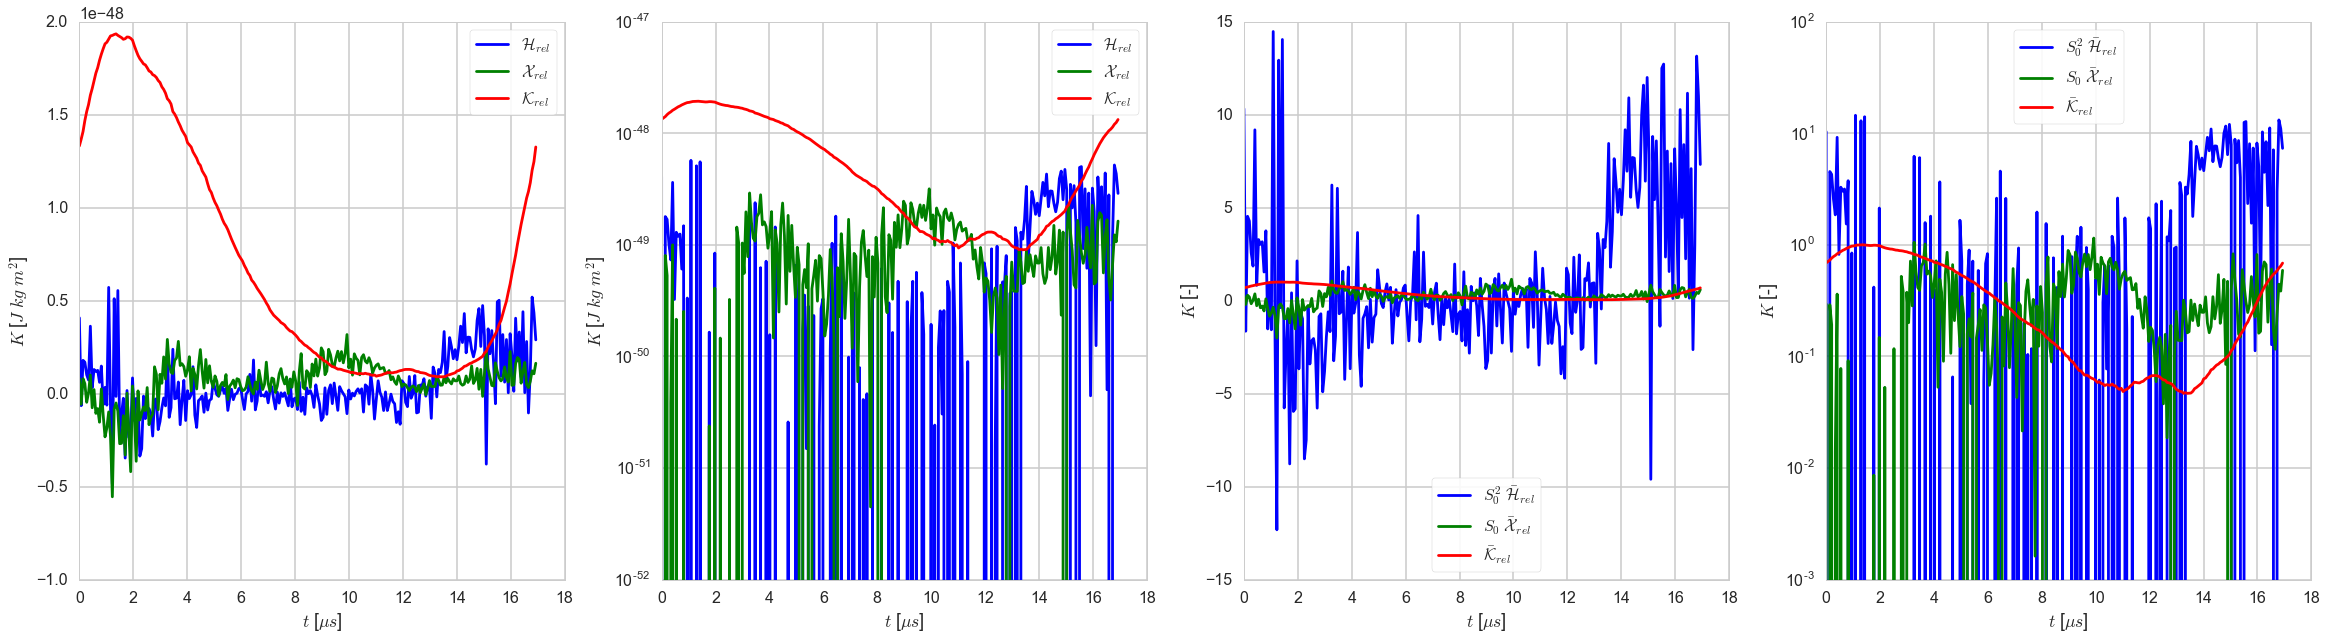

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(40,10))
axes[0] = compare_helicities(helicities, axes=axes[0],
                             magnetic=False, kinetic=False, cross=False)
axes[1] = compare_helicities(helicities, scale='log',
                             magnetic=False, kinetic=False, cross=False,
                             axes=axes[1])
axes[2] = compare_helicities(helicities, S_0_velocity='u_alfven',
                             labels_case="norm_dimless", 
                             normalize='rel',
                             magnetic=False, kinetic=False, cross=False,
                             axes=axes[2])
axes[3] = compare_helicities(helicities, scale='log', 
                             S_0_velocity='u_alfven', 
                             magnetic=False, kinetic=False, cross=False,
                             normalize='rel', axes=axes[3],
                             labels_case="norm_dimless")
plt.show()

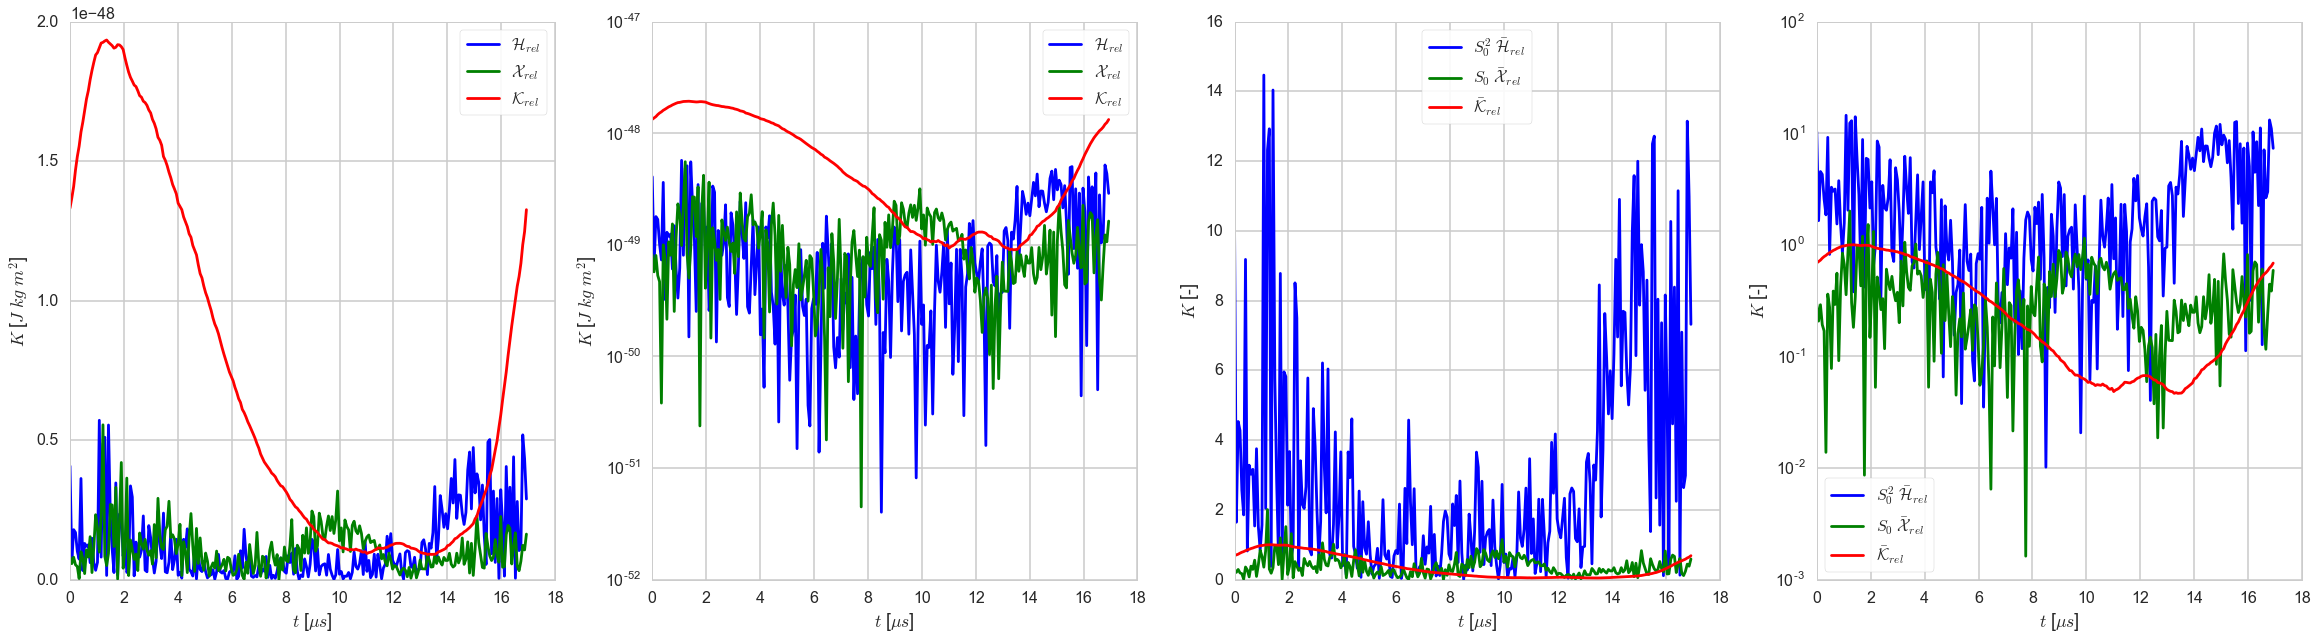

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(40,10))
axes[0] = compare_helicities(helicities, axes=axes[0],
                             magnetic=False, kinetic=False, cross=False,
                             absolute=True)
axes[1] = compare_helicities(helicities, scale='log',
                             magnetic=False, kinetic=False, cross=False,
                             axes=axes[1], absolute=True)
axes[2] = compare_helicities(helicities, S_0_velocity='u_alfven',
                             labels_case="norm_dimless", 
                             normalize='rel',
                             magnetic=False, kinetic=False, cross=False,
                             axes=axes[2], absolute=True)
axes[3] = compare_helicities(helicities, scale='log', 
                             S_0_velocity='u_alfven', 
                             magnetic=False, kinetic=False, cross=False,
                             normalize='rel', axes=axes[3],
                             labels_case="norm_dimless", absolute=True)
plt.show()

# Filter cross and kinetic helicity

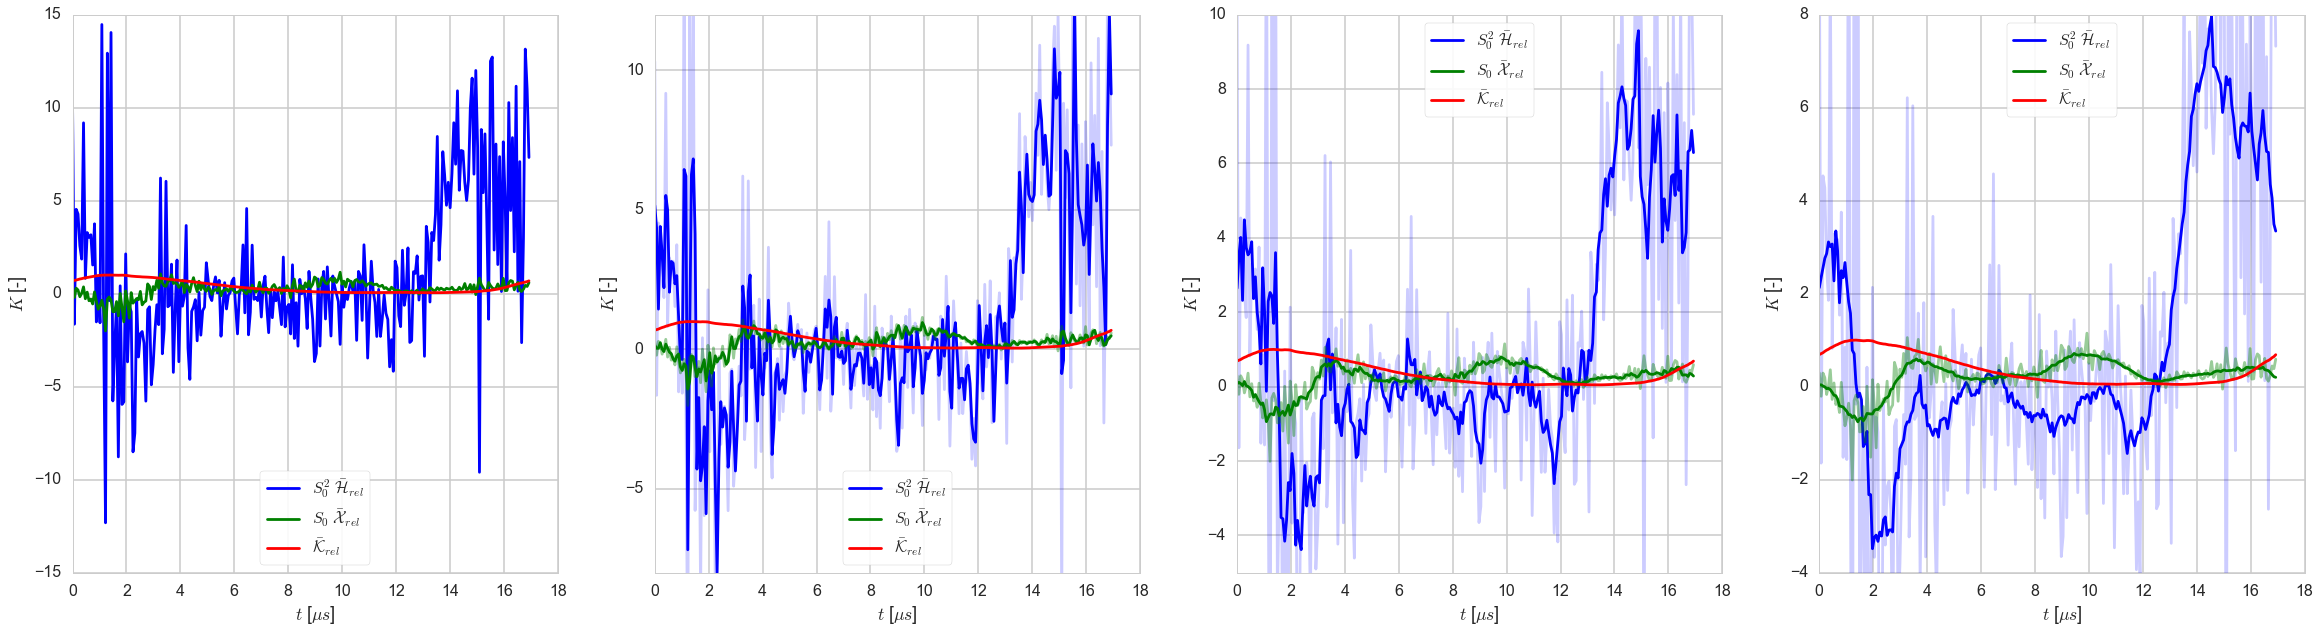

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(40,10))
axes[0] = compare_helicities(helicities,
                             S_0_velocity='u_alfven', 
                             magnetic=False, kinetic=False, cross=False,
                             normalize='rel', axes=axes[0],
                             labels_case="norm_dimless")
axes[1] = compare_helicities(helicities, 
                             S_0_velocity='u_alfven', 
                             magnetic=False, kinetic=False, cross=False,
                             normalize='rel', axes=axes[1],
                             labels_case="norm_dimless",
                             filter_width_kinetic=2, filter_width_cross=2, ylim=(-8, 12))
axes[2] = compare_helicities(helicities, 
                             S_0_velocity='u_alfven', 
                             magnetic=False, kinetic=False, cross=False,
                             normalize='rel', axes=axes[2],
                             labels_case="norm_dimless",
                             filter_width_kinetic=5, filter_width_cross=5, ylim=(-5, 10))
axes[3] = compare_helicities(helicities, 
                             S_0_velocity='u_alfven', 
                             magnetic=False, kinetic=False, cross=False,
                             normalize='rel', axes=axes[3],
                             labels_case="norm_dimless",
                             filter_width_kinetic=15, filter_width_cross=15, ylim=(-4, 8))
plt.show()

# Plot sums of helicity

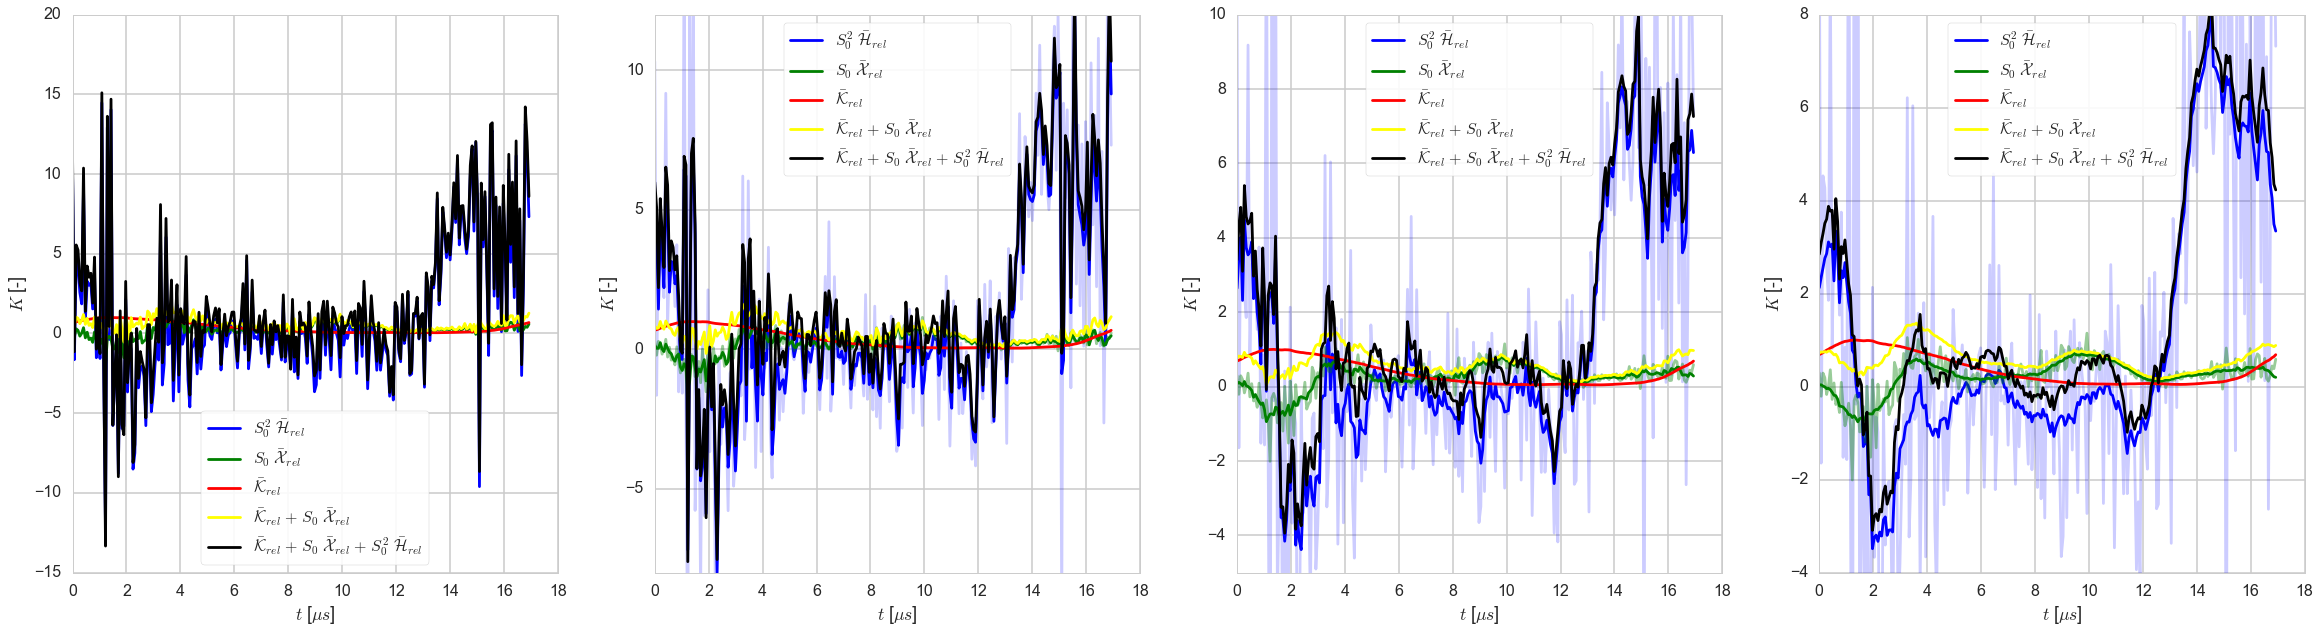

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(40,10))
axes[0] = compare_helicities(helicities,
                             S_0_velocity='u_alfven', 
                             magnetic=False, kinetic=False, cross=False,
                             normalize='rel', axes=axes[0],
                             labels_case="norm_dimless",
                              add_cross_magnetic=True, add_three=True)
axes[1] = compare_helicities(helicities, 
                             S_0_velocity='u_alfven', 
                             magnetic=False, kinetic=False, cross=False,
                             normalize='rel', axes=axes[1],
                             labels_case="norm_dimless",
                             filter_width_kinetic=2, filter_width_cross=2, ylim=(-8, 12),
                             add_cross_magnetic=True, add_three=True)
axes[2] = compare_helicities(helicities, 
                             S_0_velocity='u_alfven', 
                             magnetic=False, kinetic=False, cross=False,
                             normalize='rel', axes=axes[2],
                             labels_case="norm_dimless",
                             filter_width_kinetic=5, filter_width_cross=5, ylim=(-5, 10),
                             add_cross_magnetic=True, add_three=True)
axes[3] = compare_helicities(helicities, 
                             S_0_velocity='u_alfven', 
                             magnetic=False, kinetic=False, cross=False,
                             normalize='rel', axes=axes[3],
                             labels_case="norm_dimless",
                             filter_width_kinetic=15, filter_width_cross=15, ylim=(-4, 8),
                             add_cross_magnetic=True, add_three=True)
plt.show()

## Fourier spectrum

In [12]:
def compare_fft_helicities(helicities):
    r"""
    Plot phases and power spectrum density from ffts of signals 
    both with gauge and relative.
    """
    dt = (helicities['time'][1] - helicities['time'][0])*1e-6
    n = helicities['time'].size
    freqs = fft.fftshift(fft.fftfreq(n*3, d=dt))
    phases = {}
    magnitudes = {}
    n_half = freqs.size/2
    
    labels = {'kinetic': r'$H$',
              'relative_kinetic': r'$H_{rel}$',
              'cross': r'$X$',
              'relative_cross': r'$X_{rel}$',
              'magnetic': r'$K$',
              'relative_magnetic': r'$K_{rel}$'}
    
    fig, axes = plt.subplots(1, 2)
    keys = helicities.keys()
    keys.remove('time')
    fft_max = np.max(np.abs(fft.fft(np.pad(helicities['magnetic'], n, mode='reflect'))))**2
    for key in keys:
        fft_helicity = fft.fft(np.pad(helicities[key], n, mode='reflect'))
        magnitude = np.abs(fft_helicity)**2.
        phase = np.angle(fft_helicity)/(2*np.pi)
        magnitudes[key] = fft.fftshift(magnitude)
        phases[key] = fft.fftshift(phase)
        axes[0].plot(freqs[n_half:]*1e-6, magnitude[n_half:]/fft_max, label=labels[key])
        axes[1].plot(freqs[n_half:]*1e-6, magnitude[n_half:]/fft_max, label=labels[key])
        axes[0].set_xlabel(r'$f$ $[MHz]$')
        axes[0].set_ylabel(r'$psd$')
        axes[1].set_xlabel(r'$f$ $[M Hz]$')
        axes[1].set_ylabel(r'$psd$')
        axes[0].legend(loc='best')
        axes[1].legend(loc='best')
        axes[0].set_yscale('log')
        axes[0].set_xscale('log')
        axes[1].set_yscale('log')
        axes[1].set_xscale('log')
        #axes[1].set_xlim((7, 8))
    fig.show()

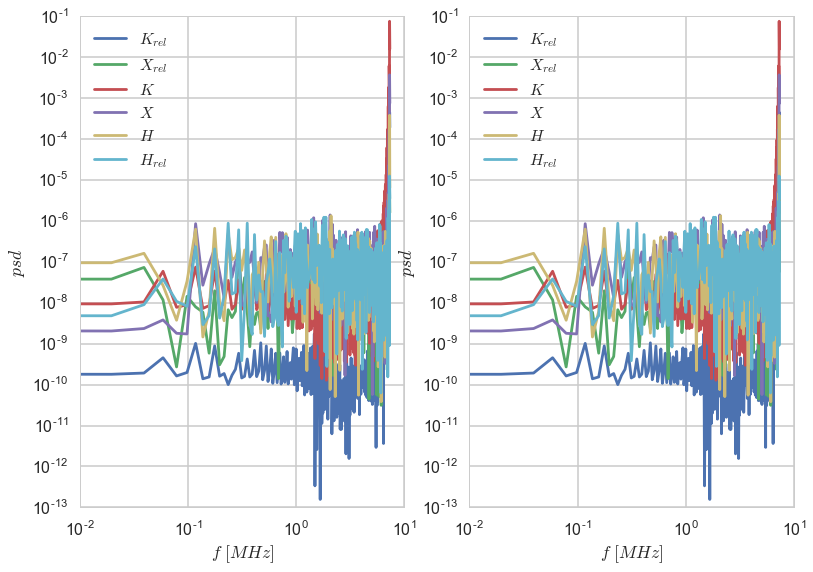

In [364]:
compare_fft_helicities(helicities)